In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sea
from scipy.interpolate import RectBivariateSpline
from mpl_toolkits.mplot3d import Axes3D

#custom modules
from plotting import create_3D_loss_manifold

sea.set(style="white")

In [7]:
mu_list = np.logspace(-3.5, -1.3, 10)
mu_list

array([0.00031623, 0.00055519, 0.00097474, 0.00171133, 0.00300454,
       0.005275  , 0.00926119, 0.01625965, 0.02854668, 0.05011872])

In [8]:
def loadmaxsics_pd(m1, m2, decay = "qq", extra = False):
    
    extra_str = "_extra" if extra else ""
    
    msicandstd1 = np.load(f"data/maxsicandstd1_script{float(m1)}{float(m2)}_{decay}{extra_str}exp4.npy", allow_pickle = True).item()
    msicandstd2 = np.load(f"data/maxsicandstd2_script{float(m1)}{float(m2)}_{decay}{extra_str}exp4.npy", allow_pickle = True).item()

    msic1_ensemble = []
    std1_ensemble = []
    msic2_ensemble = []
    std2_ensemble = []
    sigspace = np.logspace(-3,-1,10)
    for sig in sigspace:
        msic1_ensemble.append(msicandstd1[sig][0])
        std1_ensemble.append(msicandstd1[sig][1])
        msic2_ensemble.append(msicandstd2[sig][0])
        std2_ensemble.append(msicandstd2[sig][1])

    msic1_ensemble = np.array(msic1_ensemble)
    std1_ensemble = np.array(std1_ensemble)
    msic2_ensemble = np.array(msic2_ensemble)
    std2_ensemble = np.array(std2_ensemble)

    maxsicdata_pd = pd.DataFrame({
        "Semi Weak Max Sics": msic1_ensemble,
        "Semi Weak Max Sic Std": std1_ensemble,
        "CWOLA Max Sics": msic2_ensemble,
        "CWOLA Max Sic Std": std2_ensemble,
    })

    maxsicdata_pd.index = sigspace
    maxsicdata_pd.index.name = "Signal fraction"

    return maxsicdata_pd

In [2]:
#loadmaxsics_pd(5, 1,"qq", True)

In [128]:
m1,m2 = 5, 1
decay= "qq"
extra = True
extra_str = "_extra" if extra else ""
model_name = "deep-forest-83qq"
cutoff_fpr = 1e-3

tuple_rates_dedicated = np.load("tuple_rates_dedicated_benchmark_extra.npy", allow_pickle = True).item()
tuple_rates_parametrized = np.load("tuples_rates_parametrized_deep-forest-83qq.npy", allow_pickle = True).item()
tuple_rates_semiweak = np.load(f"data/good/tuplerates_script{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", allow_pickle = True).item()
tuple_rates_weak = np.load(f"data/good/tuplerates2_script{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", allow_pickle = True).item()
weight_list3 = np.array(np.load(f"data/good/weight_list3_runs_script{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy"))

fpr_full = tuple_rates_dedicated[(m1, m2)][0]
tpr_full = tuple_rates_dedicated[(m1, m2)][1]
fpr_parametrized = tuple_rates_parametrized[(m1, m2)][0]
tpr_parametrized = tuple_rates_parametrized[(m1, m2)][1]

index_full = np.argmin(np.abs(np.array(fpr_full) - cutoff_fpr))
index_parametrized = np.argmin(np.abs(np.array(fpr_parametrized) - cutoff_fpr))

fpr_full_cut = fpr_full[index_full]
tpr_full_cut = tpr_full[index_full]
fpr_parametrized_cut = fpr_parametrized[index_parametrized]
tpr_parametrized_cut = tpr_parametrized[index_parametrized]

maxsic_full = np.max(tpr_full_cut/np.sqrt(fpr_full_cut))
print(maxsic_full)

maxsic_parametrized = np.max(tpr_parametrized_cut/np.sqrt(fpr_parametrized_cut))
print(maxsic_parametrized)

sigspace = np.logspace(-3, -1, 10)
injections = 10

max_sics = []
max_sics2 = []

max_std = []
max_std2 = []
errlos = []
errhis = []
mu_stats = {}

count = 0
for sigfrac in sigspace:
    
    max_sic_injections = []
    max_sic_injections2 = []
    count2 = 0
    for injection in range(injections):

        #extract fpr and tpr, use specific fpt cut to determine SIC
        fpr = tuple_rates_semiweak[(sigfrac, injection)][0]
        tpr = tuple_rates_semiweak[(sigfrac, injection)][1]
        
        fpr2 = tuple_rates_weak[(sigfrac, injection)][0]
        tpr2 = tuple_rates_weak[(sigfrac, injection)][1]
        
        index = np.argmin(np.abs(np.array(fpr) - cutoff_fpr))
        index2 = np.argmin(np.abs(np.array(fpr2) - cutoff_fpr))
        
        fpr_cut = fpr[index]
        tpr_cut = tpr[index]
        
        fpr2_cut = fpr2[index2]
        tpr2_cut = tpr2[index2]
        
        maxsic = np.max(tpr_cut / np.sqrt(fpr_cut))
        maxsic2 = np.max(tpr2_cut / np.sqrt(fpr2_cut))
        max_sic_injections.append(maxsic)
        max_sic_injections2.append(maxsic2)
        
    mu_stats[sigfrac]=(np.median(np.median(np.exp(weight_list3[count]), axis = 1), axis = 0), np.std(np.exp(weight_list3[count])))
        
    count+=1
    errhi = np.quantile(max_sic_injections, 0.84, axis=0)
    errlo = np.quantile(max_sic_injections, 0.16, axis=0)
    errhis.append(errhi)
    errlos.append(errlo)
    max_sics.append(np.median(max_sic_injections, axis = 0))
    max_std.append(np.std(max_sic_injections, axis = 0))
    max_sics2.append(np.median(max_sic_injections2, axis = 0))
    max_std2.append(np.std(max_sic_injections2, axis = 0))

15.772891165676404
16.684575016364402


21.10910256538779

In [108]:
errhis

[20.004082134625566,
 20.80453352815223,
 21.173332334465133,
 21.144827295451172,
 21.08027476371515,
 21.186514640945962,
 21.222460208617914,
 21.212505528723884,
 21.2287116116913,
 21.21223372859026]

In [66]:
(np.quantile(max_sic_injections, 0.16), np.quantile(max_sic_injections, 0.84))

(16.529766413518495, 16.711432271488228)

In [14]:
max_sics

[4.914717418602832,
 18.518082854062353,
 21.018219395706815,
 21.080648488898888,
 20.921390598102782,
 21.094311820464725,
 21.145201020634907,
 21.172409898013626,
 21.16558603065681,
 21.10910256538779]

In [4]:
mu_stats

{0.001: (0.0040067923, 0.003591539),
 0.0016681005372000592: (0.010287998, 0.005476724),
 0.0027825594022071257: (0.01630238, 0.0070080822),
 0.004641588833612777: (0.021267146, 0.009194799),
 0.007742636826811269: (0.02928101, 0.01240037),
 0.01291549665014884: (0.03730486, 0.014331448),
 0.021544346900318832: (0.048982374, 0.021672947),
 0.03593813663804626: (0.062032133, 0.027304458),
 0.05994842503189409: (0.07805873, 0.036171854),
 0.1: (0.10138622, 0.0356711)}

In [31]:
mu_values = np.array([value[0] for value in mu_stats.values()])
mu_stds = np.array(np.flip([value[1] for value in mu_stats.values()]))

In [31]:
max_sics = np.array([value[0] for value in mu_stats.values()])
max_stds = np.array(np.flip([value[1] for value in mu_stats.values()]))

In [32]:
max_stds

array([0.00508357, 0.00610149, 0.00892715, 0.01046556, 0.01614682,
       0.01965037, 0.02505401, 0.03017853, 0.03409821, 0.04848601],
      dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


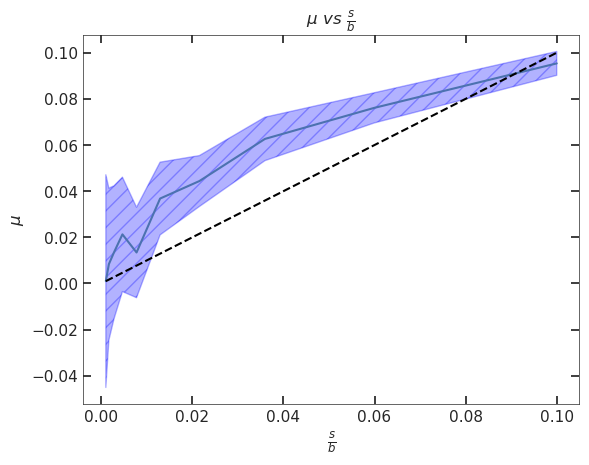

In [46]:
plt.title("$\mu \ vs \ \\frac{s}{b}$")
plt.plot(sigspace, mu_values)
plt.plot(sigspace, sigspace, linestyle='--', color = "black")
plt.fill_between(sigspace, mu_values - mu_stds, mu_values + mu_stds, color='blue', alpha=0.3, hatch = "//")
plt.xlabel("$\\frac{s}{b}$")
plt.ylabel("$\mu$")
plt.legend(loc="lower right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)

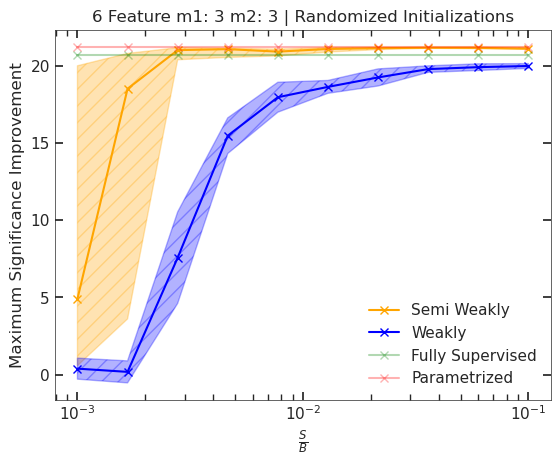

In [127]:
m1, m2 = 3, 3

msic1_ensemble = np.array(max_sics)
std1_ensemble = np.array(max_std)
msic2_ensemble = np.array(max_sics2)
std2_ensemble = np.array(max_std2)

sigspace = np.logspace(-3, -1, 10)
plt.figure()
sea.set(style="white")
plt.plot(sigspace, msic1_ensemble, marker = "x", label='Semi Weakly', color='orange')
plt.plot(sigspace, msic2_ensemble, marker = "x", label='Weakly', color='blue')
plt.plot(sigspace, [maxsic_full]*len(sigspace), marker = "x", label='Fully Supervised', color='green', alpha = 0.3)
plt.plot(sigspace, [maxsic_parametrized]*len(sigspace), marker = "x", label='Parametrized', color='red', alpha = 0.3)

plt.fill_between(sigspace, errlos, errhis, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(sigspace, msic2_ensemble - std2_ensemble, msic2_ensemble + std2_ensemble, color='blue', alpha=0.3, hatch = "//")

plt.xlabel(r'$\frac{S}{B}$')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'6 Feature m1: {m1} m2: {m2} | Randomized Initializations')
plt.xscale("log")
plt.legend(loc="lower right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
img_path = f"plots/maxsicplot{m1}{m2}_extra.png"
plt.savefig(img_path, dpi=450, bbox_inches='tight')
plt.show()

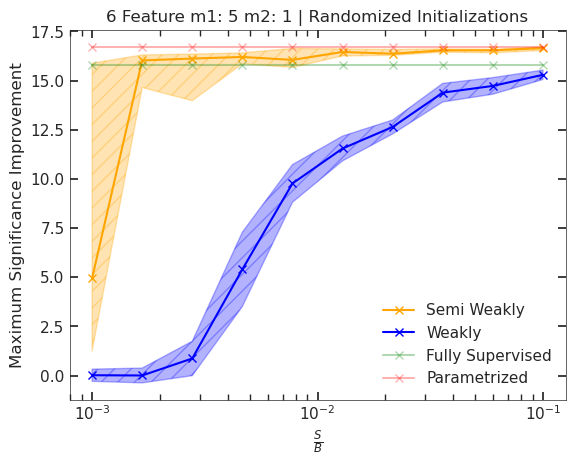

In [130]:
m1, m2 = 5, 1

msic1_ensemble = np.array(max_sics)
std1_ensemble = np.array(max_std)
msic2_ensemble = np.array(max_sics2)
std2_ensemble = np.array(max_std2)

sigspace = np.logspace(-3, -1, 10)
plt.figure()
sea.set(style="white")
plt.plot(sigspace, msic1_ensemble, marker = "x", label='Semi Weakly', color='orange')
plt.plot(sigspace, msic2_ensemble, marker = "x", label='Weakly', color='blue')
plt.plot(sigspace, [maxsic_full]*len(sigspace), marker = "x", label='Fully Supervised', color='green', alpha = 0.3)
plt.plot(sigspace, [maxsic_parametrized]*len(sigspace), marker = "x", label='Parametrized', color='red', alpha = 0.3)

plt.fill_between(sigspace, errlos, errhis, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(sigspace, msic2_ensemble - std2_ensemble, msic2_ensemble + std2_ensemble, color='blue', alpha=0.3, hatch = "//")

plt.xlabel(r'$\frac{S}{B}$')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'6 Feature m1: {m1} m2: {m2} | Randomized Initializations')
plt.xscale("log")
plt.legend(loc="lower right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
img_path = f"plots/maxsicplot{m1}{m2}_extra.png"
plt.savefig(img_path, dpi=450, bbox_inches='tight')
plt.show()

In [10]:
#from plotting import create_3D_loss_manifold
import imageio
m1,m2 = 3, 3
z = np.load(f"data/landscapes/z_6_3_{m1}{m2}_0.25_qq_extra.npy", allow_pickle = True).item()
#sigspace = np.flip(np.logspace(-3,-1,10)[0])

step = 0.25
elv = 60
azim = 20
frames = []
for azim in np.arange(0, 360, 1):
    create_3D_loss_manifold(0.001, m1, m2, z, step, elev, azim, save=False, decay="qq")
    
    plt.draw()
    frame = np.array(plt.gcf().canvas.renderer.buffer_rgba())
    frames.append(frame)
    
    plt.close()

imageio.mimsave('loss_manifold_rotate.gif', frames)
#plot = create_3D_loss_manifold(sigspace, m1, m2, z, step, elv, azim, save = False, decay = "qq")

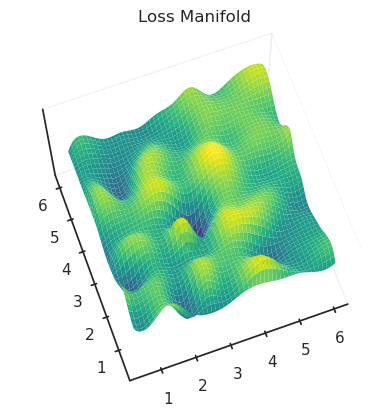

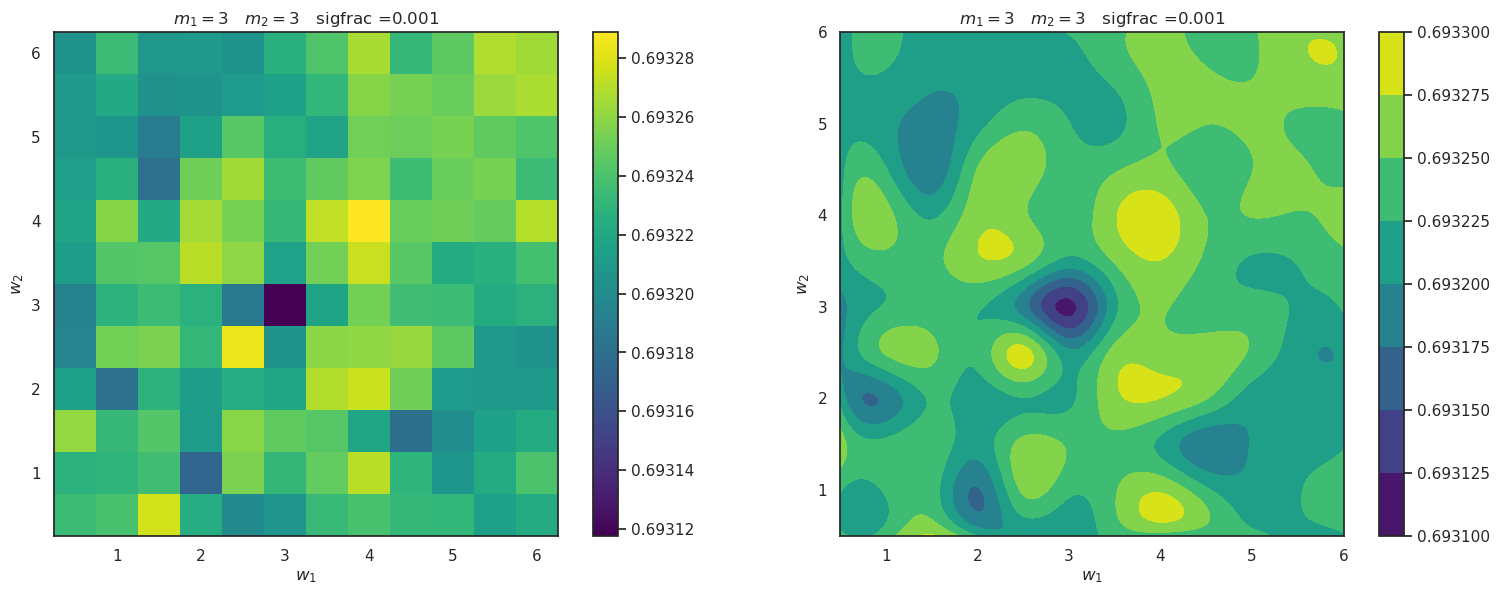

In [15]:
def plot_interpolated_landscape(sigfrac, m1, m2, z, step, decay = "qq", save = False):

    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)

    x_values = weight_list
    y_values = weight_list

    x, y = np.meshgrid(x_values, y_values)

    #loss_values_flat = np.array(z[1e-6, 5, 1, "qq"])[:,0]
    loss_values_flat = z[sigfrac, m1, m2, decay]
    loss_values = np.array(loss_values_flat).reshape(x.shape)

    interp_spline = RectBivariateSpline(x_values, y_values, loss_values, s = 0)

    xi, yi = np.meshgrid(np.linspace(min(x_values), max(x_values), 1000), np.linspace(min(y_values), max(y_values), 1000))
    zi = interp_spline(xi[0, :], yi[:, 0])
    
    #3d projection
    fig = plt.figure()
    ax3d = fig.add_subplot(111, projection='3d')
    ax3d.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', linewidth = 0)
    ax3d.set_title("Loss Manifold")
    ax3d.xaxis.pane.fill = False
    ax3d.yaxis.pane.fill = False
    ax3d.zaxis.pane.fill = False

    ax3d.grid(False)
    
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax3d.set_zticks([])
    ax3d.view_init(elev=70, azim=250)

    #2d projection
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    h0 = ax[0].pcolormesh(x, y, loss_values, cmap='viridis')
    ax[0].set_aspect("equal")
    ax[0].set_title(f"$m_{1} = {m1} \quad m_{2} = {m2} \quad$" + f"sigfrac ={sigfrac}")
    ax[0].set_xlabel(r"$w_{1}$")
    ax[0].set_ylabel(r"$w_{2}$")
    cbar = plt.colorbar(h0, ax=ax[0])    
    
    h1 = ax[1].contourf(xi, yi, zi, cmap='viridis')
    ax[1].set_aspect("equal")
    ax[1].set_title(f"$m_{1} = {m1} \quad m_{2} = {m2} \quad$" + f"sigfrac ={sigfrac}")
    ax[1].set_xlabel(r"$w_{1}$")
    ax[1].set_ylabel(r"$w_{2}$")
    cbar = plt.colorbar(h1, ax=ax[1])
    
    plt.tight_layout()
    if save == True:
        plt.savefig(f'plots/interpolation{float(m1)}{float(m2)}.png', dpi=450, bbox_inches='tight')
        
z = np.load("data/landscapes/z_6_3_33_0.5_qq_swift-night-80exp4.npy", allow_pickle = True).item()
plot_interpolated_landscape(1e-3, 3, 3, z, 0.5, "qq", save = False)

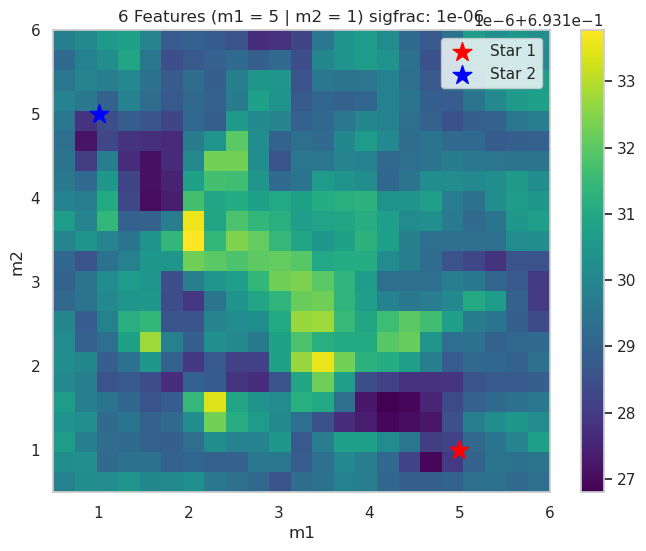

In [52]:
import numpy as np
import matplotlib.pyplot as plt

feature_dims = 6
parameters = 3
m1, m2 = 5, 1
step = 0.25
decay = "qq"
# Load data
z = np.load(f"data/landscapes/z_{feature_dims}_{parameters}_{m1}{m2}_{step}_{decay}_exp8.npy", allow_pickle=True).item()
z = np.array(z[1e-6, 5, 1, "qq"])

# Define grid axes
start = 0.5
end = 6
step = 0.25  # Define your step value here
weight_list = np.arange(start, end + step, step)
grid_axes = [(w1, w2) for w1 in weight_list for w2 in weight_list]
w1_values, w2_values = zip(*grid_axes)

# Extract loss values
loss_values = z
min_loss = min(loss_values)
max_loss = max(loss_values)

# Define the number of bins for the histogram
bins = int(np.sqrt(len(z)))

# Coordinates for stars
star1_coords = (m1, m2)  # You need to define m1 and m2
star2_coords = (m2, m1)  # You need to define m1 and m2

# Plotting
plt.figure(figsize=(8, 6))
h = plt.hist2d(w1_values, w2_values, bins=(bins, bins), cmap='viridis', weights=loss_values, vmin=min_loss, vmax=max_loss)
plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
#plt.colorbar(label='Loss (BCE)')
plt.colorbar(h[3])
plt.xlabel('m1')
plt.ylabel('m2')
plt.title(f"6 Features (m1 = {m1} | m2 = {m2}) sigfrac: {1e-6}")
plt.legend()
plt.show()


In [26]:
z.keys()

dict_keys([(0.001, 5, 1, 'qq'), (0.0016681005372000592, 5, 1, 'qq'), (0.0027825594022071257, 5, 1, 'qq'), (0.004641588833612777, 5, 1, 'qq'), (0.007742636826811269, 5, 1, 'qq'), (0.01291549665014884, 5, 1, 'qq'), (0.021544346900318832, 5, 1, 'qq'), (0.03593813663804626, 5, 1, 'qq'), (0.05994842503189409, 5, 1, 'qq'), (0.1, 5, 1, 'qq')])

In [21]:
def loss_landscape_nofit(sigfrac, m1, m2, z, step=0.25, save = False, decay = "qq"):
    start = 0.5
    end = 6
    step = step
    
    weight_list = np.arange(start, end + step, step)
    grid_axes = [(w1, w2) for w1 in weight_list for w2 in weight_list]
    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2, decay])
    min_loss = min(loss_values)
    max_loss = max(loss_values)
    #normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    bins = int(np.sqrt(len(z[sigfrac, m1, m2, decay])))

    star1_coords = (m1, m2)
    star2_coords = (m2, m1)

    plt.figure(figsize=(8, 6))
    h = plt.hist2d(w1_values, w2_values, bins=(bins, bins), cmap='viridis', weights=loss_values)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('6 Features (m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    plt.colorbar(h[3])
    plt.legend()
    plt.show()
    
    if save == True:
        plt.savefig(f'plots/landscape{float(m1)}{float(m2)}_{decay}.png', dpi=450, bbox_inches='tight')
    
    return h

In [30]:
def create_3D_loss_manifold(sigfrac, m1, m2, z, step, elev, azim, save = False, decay = "qq"):

    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)

    grid_axes = []
    for w1 in weight_list:
        for w2 in weight_list:
            grid_axes.append((w1, w2))

    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2, decay])

    x = w1_values
    y = w2_values
    z = loss_values

    sea.set(style="whitegrid")
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='r', marker='.', alpha = 0.1)
    ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

    ax.set_xlabel('W1')
    ax.set_ylabel('W2')
    ax.set_zlabel('Loss')
    ax.set_title(f"Loss Manifold m1: {m1} m2: {m2} sigfrac: {np.round(sigfrac, 4)}")

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.grid(False)
    
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=elev, azim=azim)
    
    if save == True:
        plt.savefig(f'plots/manifold{float(m1)}{float(m2)}.png', dpi=450, bbox_inches='tight')
    return ax

In [172]:
def AUC_landscape_nofit(sigfrac, m1, m2, a, step=0.25, save = False):
    start = 0.5
    end = 6
    step = step
    
    weight_list = np.arange(start, end + step, step)
    grid_axes = [(w1, w2) for w1 in weight_list for w2 in weight_list]
    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(a[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)
    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    bins = int(np.sqrt(len(z[sigfrac, m1, m2])))

    star1_coords = (m1, m2)
    star2_coords = (m2, m1)

    plt.figure(figsize=(8, 6))
    h = plt.hist2d(w1_values, w2_values, bins=(bins, bins), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.colorbar(label='Loss (BCE)')
    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('6 Features (m1 = {} | m2 = {}) sigfrac AUC Landscape: {:.4f}'.format(m1, m2, sigfrac))
    plt.legend()
    plt.show()
    
    if save == True:
        plt.savefig(f'plots/landscape{float(m1)}{float(m2)}.png', dpi=450, bbox_inches='tight')
    
    return h

In [55]:
def plot_landscapes(sigfrac, m1, m2, z, a, step, save = False):
    start = 0.5
    end = 6
    step = step

    #weightspace
    weight_list = np.arange(start, end + step, step)
    grid_axes = [(w1, w2) for w1 in weight_list for w2 in weight_list]
    w1_values, w2_values = zip(*grid_axes)

    #loss
    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)
    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    AUC_values = list(a[sigfrac, m1, m2])
    min_AUC = min(AUC_values)
    max_AUC = max(AUC_values)
    normalized_AUC = [(x - min_AUC) / (max_AUC - min_AUC) for x in AUC_values]

    bins = int(np.sqrt(len(a[sigfrac, m1, m2])))

    star1_coords = (m1, m2)
    star2_coords = (m2, m1)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].hist2d(w1_values, w2_values, bins = (bins, bins), cmap='viridis', weights=normalized_loss)
    ax[0].set_aspect("equal")
    ax[0].set_title(f"Loss Landscape")
    ax[0].set_xlabel(r"$w_{1}$")
    ax[0].set_ylabel(r"$w_{2}$")
    ax[0].scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    ax[0].scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    
    ax[1].hist2d(w1_values, w2_values, bins = (bins, bins), cmap='viridis', weights=normalized_AUC)
    ax[1].set_aspect("equal")
    ax[1].set_title("AUC Landscape")
    ax[1].set_xlabel(r"$w_{1}$")
    ax[1].set_ylabel(r"$w_{2}$")
    ax[1].scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    ax[1].scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')

    # Create colorbars associated with each subplot
    cbar1 = fig.colorbar(ax[0].collections[0], ax=ax[0])
    cbar2 = fig.colorbar(ax[1].collections[0], ax=ax[1])

    # Set label for colorbars
    cbar1.set_label('Loss')
    cbar2.set_label('AUC')
    
    plt.subplots_adjust(top=0.85)
    #plt.tight_layout()
    fig.suptitle(f"$m_{1}: ${m1 * 100} $m_{2}: {m2 * 100}$")
    if save == True:
        plt.savefig(f'plots/bothlandscape{float(m1)}{float(m2)}.png', dpi=450, bbox_inches='tight')
    return ax

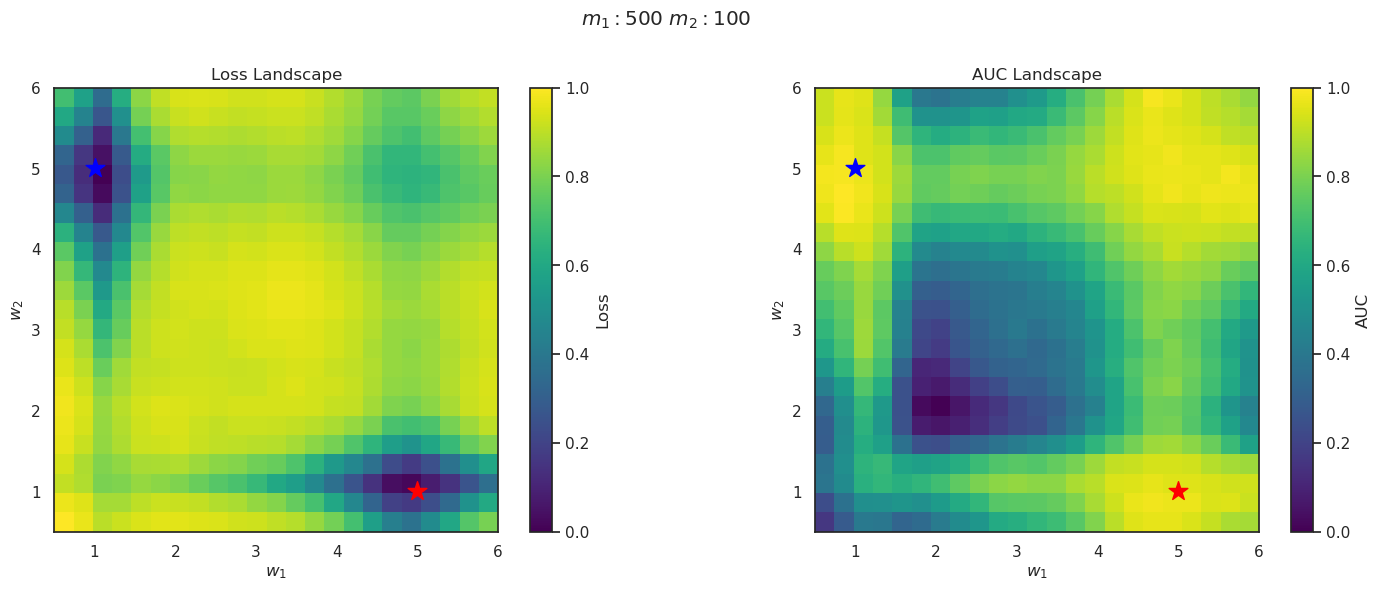

In [57]:
feature_dims = 6
parameters = 3
m1 = 5
m2 = 1
step = 0.25
z = np.load(f"data/landscapes/z_{feature_dims}_{parameters}_{m1}{m2}_{step}.npy", allow_pickle = True).item()
a = np.load(f"data/landscapes/a_{feature_dims}_{parameters}_{m1}{m2}_{step}.npy", allow_pickle = True).item()
plot_landscapes(0.1, m1, m2, z, a, step, save = True);

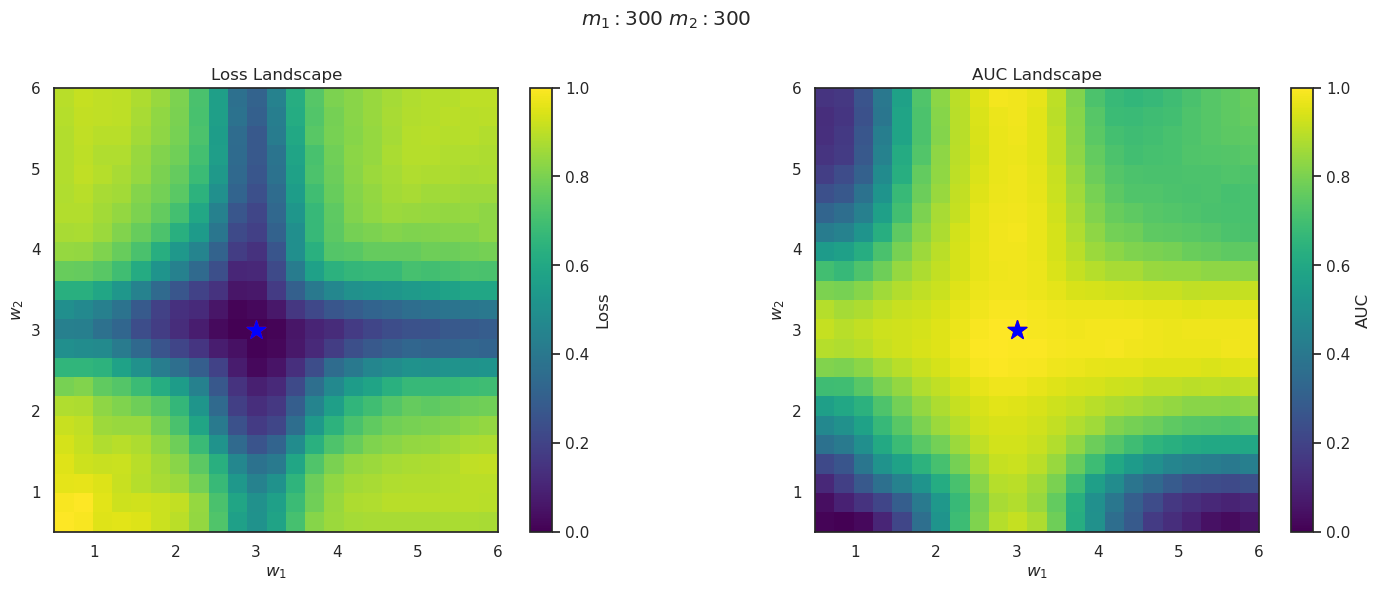

In [58]:
feature_dims = 6
parameters = 3
m1 = 3
m2 = 3
step = 0.25
z = np.load(f"data/landscapes/z_{feature_dims}_{parameters}_{m1}{m2}_{step}.npy", allow_pickle = True).item()
a = np.load(f"data/landscapes/a_{feature_dims}_{parameters}_{m1}{m2}_{step}.npy", allow_pickle = True).item()
plot_landscapes(0.1, m1, m2, z, a, step, save = True);

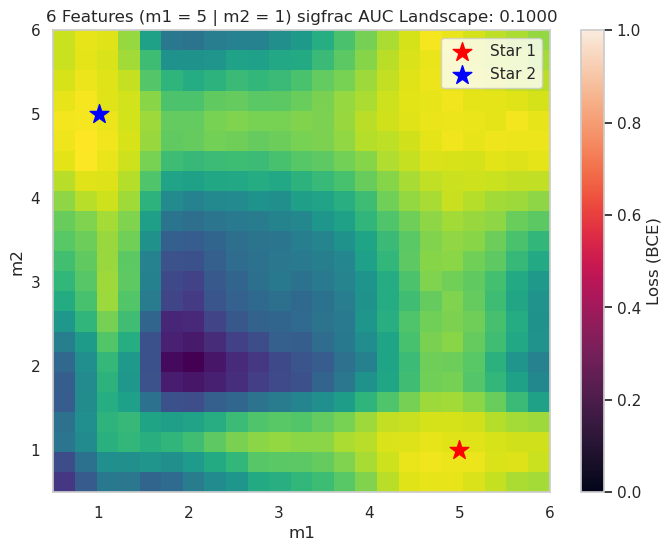

In [173]:
AUC_landscape_nofit(0.1, 5, 1, a, 0.25, False);

In [ ]:
from IPython.display import display, clear_output
from PIL import Image, ImageSequence
def create_gif_nofit(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sb in sig_space:
    
        loss_landscape_nofit(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sb}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        # Append the image to the frames list
        frames.append(Image.open(image_path))

    # Create the final GIF that combines all frames
    output_gif_filename = f'sigspace{m1}{m2}fixed.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)